In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Oxygen in temperature space
Create some preliminary plots of the relationship between o2 and temp in ESM4

NOTES
- [ ] Select below the climatological winter mixed layer depth
- [x] Break it down by basin

In [109]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt

In [110]:
pathDict = {'pp':('/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/'+
                    'gfdl.ncrc4-intel16-prod-openmp/pp'),
            'out':'av',
            'local':'annual_5yr',
            'time':'0396-0400',
            'add':'ann'}
pathDict['ppname']='ocean_cobalt_omip_tracers_year_z_1x1deg'
path=gu.core.get_pathspp(**pathDict)
gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
# gu.core.issue_dmget(path)
# gu.core.issue_dmget(gridpath)
ds_cobalt = gu.core.open_frompp(**pathDict)
pathDict['ppname']='ocean_annual_z_1x1deg'
path=gu.core.get_pathspp(**pathDict)
gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
# gu.core.issue_dmget(path)
# gu.core.issue_dmget(gridpath)
ds_mom = gu.core.open_frompp(**pathDict)
grid = xr.open_dataset(gridpath)

ds = xr.merge([ds_mom['so'],ds_mom['thetao'],ds_mom['volcello'],ds_cobalt['o2']])

In [111]:
# Select Southern Ocean
SOlat = -30
dsSO = ds.where(grid['geolat']<=SOlat,drop=True)
# Select subsurface
# dsSO = dsSO.sel({'z_l':slice(200,7000)})

In [112]:
thetao_bins = np.arange(-2,20,0.5)
o2_bins = np.arange(0,0.5,0.01)
hs2d = xr.Dataset()
hs2d['volcello'] = histogram(dsSO['thetao'],dsSO['o2'],
                             bins=[thetao_bins,o2_bins],
                             weights=dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs2d = hs2d.squeeze()
# normalize in each temperature bin
hs2d = hs2d/hs2d.sum('o2_bin')

In [129]:
def plot_hs(hs,ax):
    hs = hs.squeeze()
    # stats
    o2array = hs['o2_bin']*xr.ones_like(hs['volcello'])
    stats = xr.Dataset()
    stats['mean'] = o2array.weighted(hs['volcello'].fillna(0)).mean('o2_bin')
    stats['std'] = o2array.weighted(hs['volcello'].fillna(0)).std('o2_bin')
    
    # plot
    im=ax.pcolormesh(hs['thetao_bin'],
                  hs['o2_bin'],
                  hs['volcello'].transpose(),
                  cmap='magma_r',
                  vmax=0.5)
    cb = plt.colorbar(im,ax=ax)
    ax.errorbar(stats['thetao_bin'],stats['mean'],yerr=stats['std'],
                linestyle='',
                marker='o',
                markerfacecolor='w',
                markeredgecolor='gray',
                ecolor='gray',
                alpha=0.5,
                label='Weighted-mean O2 in each temperature bin')
    ax.legend()
    ax.set_ylabel('OXYGEN [mol m-3]')
    ax.set_xlabel('TEMPERATURE [degC]')
    cb.ax.set_ylabel('FRACTION \n(in each temperature bin)');

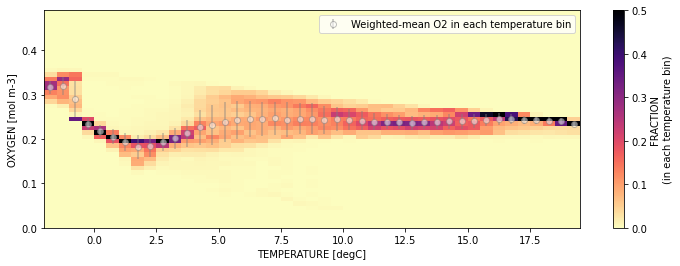

In [130]:
fig,ax = plt.subplots(figsize=(12,4))
plot_hs(hs2d,ax)

### Basin break-down

In [137]:
lon_bins = np.array([-300,-230,-150,-70,20,50])
dsSO['geolon']=(grid*xr.ones_like(dsSO['o2']))['geolon']
hs3d = xr.Dataset()
hs3d['volcello'] = histogram(dsSO['thetao'],dsSO['o2'],dsSO['geolon'],
                             bins=[thetao_bins,o2_bins,lon_bins],
                             weights=dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs3d = hs3d.squeeze()
basins=['IndianEast','PacificWest','PacificEast','Atlantic','IndianWest']
hs3d = hs3d.rename({'geolon_bin':'basin'}).assign_coords({'basin':basins})
# normalize in each temperature bin
hs3d = hs3d/hs3d.sum('o2_bin')

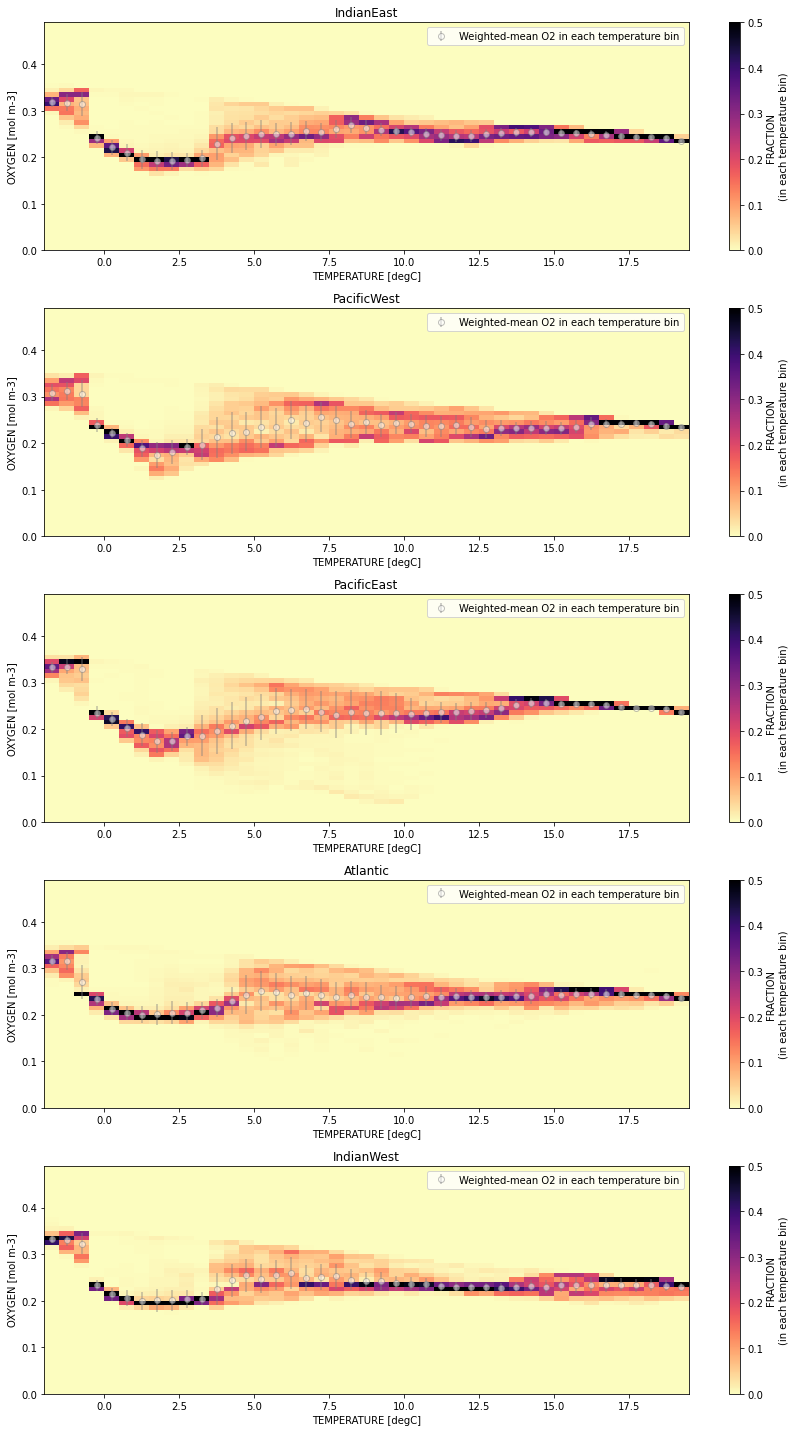

In [138]:
nb = len(hs3d['basin'])
fig,axarr = plt.subplots(figsize=(12,4*nb),nrows=nb)
for i,basin in enumerate(hs3d['basin']):
    ax = axarr.flat[i]
    plot_hs(hs3d.sel({'basin':basin}),ax)
    ax.set_title(basin.values)
fig.tight_layout()

# ARCHIVE

In [94]:
thetao_bins = np.arange(-2,30,0.5)
hs = xr.Dataset()
hs['o2volcello'] = histogram(dsSO['thetao'],
                             bins=thetao_bins,
                             weights=dsSO['o2']*dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs['volcello'] = histogram(dsSO['thetao'],
                             bins=thetao_bins,
                             weights=dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs['o2'] = hs['o2volcello']/hs['volcello']
hs = hs.squeeze()

In [76]:
ds['o2']

<xarray.DataArray 'o2' (time: 1, z_l: 35, lat: 180, lon: 360)>
dask.array<open_dataset-185ccec6c31594300b6aab13bee8011co2, shape=(1, 35, 180, 360), dtype=float32, chunksize=(1, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0398-07-02 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Dissolved Oxygen Concentration
    units:          mol m-3
    cell_measures:  volume: volcello area: areacello
    standard_name:  mole_concentration_of_dissolved_molecular_oxygen_in_sea_w...
    interp_method:  conserve_order1
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT